# Transformer Decoder デモ

このノートブックでは、Transformer Decoderの構造を学びます。

## Decoderの構成要素

DecoderはEncoderと似ていますが、2つの重要な違いがあります：

1. **Masked Self-Attention** - 未来のトークンを見ない
2. **Cross-Attention** - Encoder出力を参照する

```
入力
  ↓
┌─────────────────┐
│ Masked          │
│ Self-Attention  │  ← 未来を見ないマスク
└────────┬────────┘
  ↓      │
Add & Norm ←─┘
  ↓
┌─────────────────┐
│ Cross-Attention │  ← Q=Decoder, K,V=Encoder
└────────┬────────┘
  ↓      │
Add & Norm ←─┘
  ↓
┌─────────────────┐
│ Feed Forward    │
│ Network         │
└────────┬────────┘
  ↓      │
Add & Norm ←─┘
  ↓
出力
```

In [1]:
import sys
sys.path.append('..')

# Jupyterでのモジュールキャッシュ問題を回避
for mod_name in list(sys.modules.keys()):
    if mod_name.startswith('src'):
        del sys.modules[mod_name]

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from src.decoder import (
    generate_causal_mask, DecoderLayer, Decoder, TransformerDecoder
)
from src.encoder import Encoder, TransformerEncoder
from src.attention import MultiHeadAttention

# 日本語フォント設定（macOS）
plt.rcParams['font.family'] = 'Hiragino Sans'

# 再現性のためのシード設定
torch.manual_seed(42)

print('モジュール読み込み完了 ✓')

モジュール読み込み完了 ✓


## 1. Causal Mask（因果マスク）

### なぜマスクが必要か？

Decoderは次のトークンを予測するタスクです。
学習時に未来のトークンが見えてしまうと「カンニング」になります。

```
入力: "I love cats"
予測: "love" を予測するとき、"cats" を見てはいけない
```

### Causal Maskの構造

下三角行列で、各位置から見える範囲を制限：

```
位置0: [見える, 見えない, 見えない, 見えない]
位置1: [見える, 見える,   見えない, 見えない]
位置2: [見える, 見える,   見える,   見えない]
位置3: [見える, 見える,   見える,   見える  ]
```

Causal Mask (6x6):
[[1 0 0 0 0 0]
 [1 1 0 0 0 0]
 [1 1 1 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 1]]


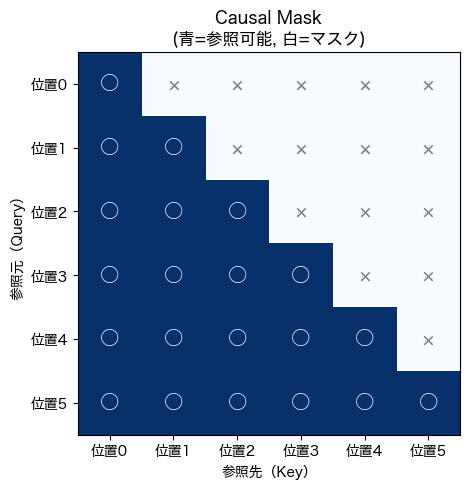


→ 各位置は自分より前の位置しか見えない（未来は見えない）


In [2]:
# Causal Maskの生成と可視化

seq_len = 6
mask = generate_causal_mask(seq_len)

print("Causal Mask (6x6):")
print(mask.int().numpy())

# 可視化
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(mask.int().numpy(), cmap='Blues', vmin=0, vmax=1)

# ラベル
positions = [f'位置{i}' for i in range(seq_len)]
ax.set_xticks(range(seq_len))
ax.set_yticks(range(seq_len))
ax.set_xticklabels(positions)
ax.set_yticklabels(positions)
ax.set_xlabel('参照先（Key）')
ax.set_ylabel('参照元（Query）')
ax.set_title('Causal Mask\n(青=参照可能, 白=マスク)')

# 値を表示
for i in range(seq_len):
    for j in range(seq_len):
        text = '○' if mask[i, j] else '×'
        color = 'white' if mask[i, j] else 'gray'
        ax.text(j, i, text, ha='center', va='center', color=color, fontsize=14)

plt.tight_layout()
plt.show()

print("\n→ 各位置は自分より前の位置しか見えない（未来は見えない）")

## 2. Masked Self-Attention

Causal Maskを適用したSelf-Attentionを見てみましょう。

/var/folders/2g/vjpf8_jn6dq3z6qmf68msfwm0000gn/T/ipykernel_47959/1328739692.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


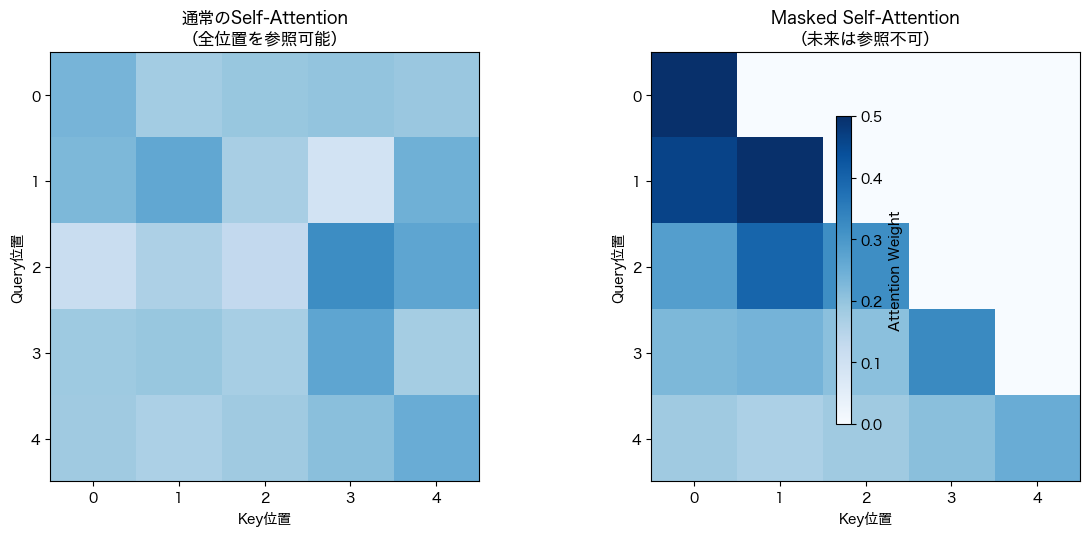

→ Masked版では上三角部分（未来）の重みが0になっている


In [3]:
# Masked Self-Attentionの動作

d_model = 64
num_heads = 4
seq_len = 5

# 入力
x = torch.randn(1, seq_len, d_model)

# Multi-Head Attention
attention = MultiHeadAttention(d_model, num_heads, dropout=0.0)

# マスクなしとありで比較
# Causal Maskにバッチ次元を追加: [seq_len, seq_len] → [1, seq_len, seq_len]
causal_mask = generate_causal_mask(seq_len).unsqueeze(0)

with torch.no_grad():
    # マスクなし（通常のSelf-Attention）
    _, weights_no_mask = attention(x, x, x, mask=None)
    
    # マスクあり（Masked Self-Attention）
    _, weights_masked = attention(x, x, x, mask=causal_mask)

# 可視化（カラーバー用のスペースを確保）
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(right=0.88)

# マスクなし
im1 = axes[0].imshow(weights_no_mask[0, 0].numpy(), cmap='Blues', vmin=0, vmax=0.5)
axes[0].set_title('通常のSelf-Attention\n（全位置を参照可能）')
axes[0].set_xlabel('Key位置')
axes[0].set_ylabel('Query位置')

# マスクあり
im2 = axes[1].imshow(weights_masked[0, 0].numpy(), cmap='Blues', vmin=0, vmax=0.5)
axes[1].set_title('Masked Self-Attention\n（未来は参照不可）')
axes[1].set_xlabel('Key位置')
axes[1].set_ylabel('Query位置')

# カラーバーを右端に配置
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='Attention Weight')
plt.show()

print("→ Masked版では上三角部分（未来）の重みが0になっている")

## 3. Cross-Attention

Cross-Attentionは、Decoder状態（Q）からEncoder出力（K, V）を参照します。

```
Encoder出力: [h₁, h₂, h₃, ...]  ← 入力文の表現
              ↓   ↓   ↓
           K, V として使用

Decoder状態: [d₁, d₂, d₃, ...]  ← 生成中の文の表現
              ↓   ↓   ↓
           Q として使用
```

翻訳の例：
- Encoder入力: "I love cats" (英語)
- Decoder出力: "私は猫が好き" (日本語)
- Cross-Attention: 「猫」を生成するとき「cats」に注目

Decoder状態 (Q): torch.Size([1, 4, 64])
Encoder出力 (K, V): torch.Size([1, 6, 64])
Cross-Attention出力: torch.Size([1, 4, 64])
Cross-Attention重み: torch.Size([1, 4, 4, 6])


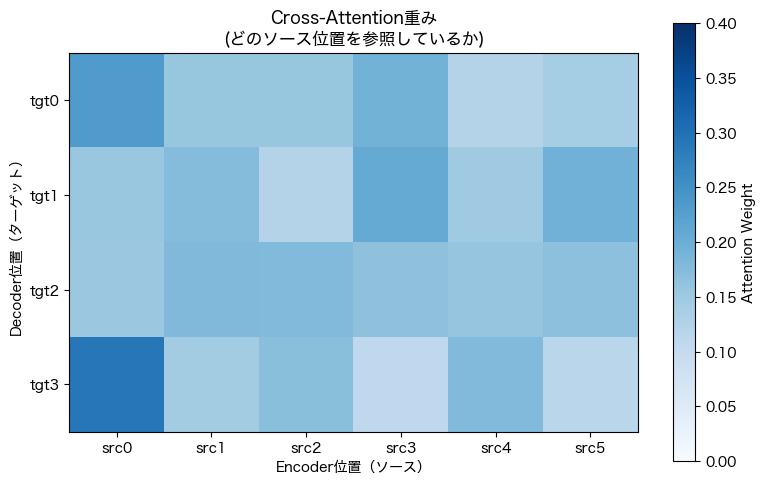

In [4]:
# Cross-Attentionの動作

src_len = 6  # Encoder側（ソース）の長さ
tgt_len = 4  # Decoder側（ターゲット）の長さ

# Encoder出力（ソース文の表現）
encoder_output = torch.randn(1, src_len, d_model)

# Decoder状態（生成中のターゲット文）
decoder_state = torch.randn(1, tgt_len, d_model)

# Cross-Attention: Q=Decoder, K,V=Encoder
cross_attention = MultiHeadAttention(d_model, num_heads, dropout=0.0)

with torch.no_grad():
    output, cross_weights = cross_attention(
        query=decoder_state,
        key=encoder_output,
        value=encoder_output
    )

print(f"Decoder状態 (Q): {decoder_state.shape}")
print(f"Encoder出力 (K, V): {encoder_output.shape}")
print(f"Cross-Attention出力: {output.shape}")
print(f"Cross-Attention重み: {cross_weights.shape}")

# 可視化
fig, ax = plt.subplots(figsize=(8, 5))

# 重みの平均（全ヘッド）
avg_weights = cross_weights[0].mean(dim=0).numpy()

im = ax.imshow(avg_weights, cmap='Blues', vmin=0, vmax=0.4)
ax.set_xlabel('Encoder位置（ソース）')
ax.set_ylabel('Decoder位置（ターゲット）')
ax.set_title('Cross-Attention重み\n(どのソース位置を参照しているか)')

# ラベル
ax.set_xticks(range(src_len))
ax.set_yticks(range(tgt_len))
ax.set_xticklabels([f'src{i}' for i in range(src_len)])
ax.set_yticklabels([f'tgt{i}' for i in range(tgt_len)])

plt.colorbar(im, label='Attention Weight')
plt.tight_layout()
plt.show()

## 4. Decoder Layer

DecoderLayerは3つのサブレイヤーで構成：

1. **Masked Self-Attention + Add & Norm**
2. **Cross-Attention + Add & Norm**
3. **FFN + Add & Norm**

In [5]:
# DecoderLayerの構造を確認

decoder_layer = DecoderLayer(d_model, num_heads, dropout=0.0)

print("DecoderLayer の構造")
print("=" * 50)
print(decoder_layer)

# パラメータ数
params = sum(p.numel() for p in decoder_layer.parameters())
print(f"\nパラメータ数: {params:,}")

DecoderLayer の構造
DecoderLayer(
  (self_attention): MultiHeadAttention(
    (W_q): Linear(in_features=64, out_features=64, bias=False)
    (W_k): Linear(in_features=64, out_features=64, bias=False)
    (W_v): Linear(in_features=64, out_features=64, bias=False)
    (attention): ScaledDotProductAttention(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (W_o): Linear(in_features=64, out_features=64, bias=False)
  )
  (cross_attention): MultiHeadAttention(
    (W_q): Linear(in_features=64, out_features=64, bias=False)
    (W_k): Linear(in_features=64, out_features=64, bias=False)
    (W_v): Linear(in_features=64, out_features=64, bias=False)
    (attention): ScaledDotProductAttention(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (W_o): Linear(in_features=64, out_features=64, bias=False)
  )
  (feed_forward): FeedForward(
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=64, bias=True)
    (dropout): Dr

In [6]:
# DecoderLayerの順伝播

batch_size = 1
src_len = 8
tgt_len = 5

# 入力
decoder_input = torch.randn(batch_size, tgt_len, d_model)
encoder_output = torch.randn(batch_size, src_len, d_model)

# Causal Mask（バッチ次元を追加）
tgt_mask = generate_causal_mask(tgt_len).unsqueeze(0)

with torch.no_grad():
    output = decoder_layer(decoder_input, encoder_output, tgt_mask=tgt_mask)

print("DecoderLayer 順伝播")
print("=" * 50)
print(f"Decoder入力: {decoder_input.shape}")
print(f"Encoder出力: {encoder_output.shape}")
print(f"Decoder出力: {output.shape}")

DecoderLayer 順伝播
Decoder入力: torch.Size([1, 5, 64])
Encoder出力: torch.Size([1, 8, 64])
Decoder出力: torch.Size([1, 5, 64])


## 5. Encoder-Decoder の連携

完全なTransformerは Encoder + Decoder で構成されます。

In [7]:
# Encoder + Decoder の連携

d_model = 64
num_heads = 4
num_layers = 2

# Encoder
encoder = Encoder(d_model, num_heads, num_layers, dropout=0.0)

# Decoder
decoder = Decoder(d_model, num_heads, num_layers, dropout=0.0)

# 入力
src = torch.randn(1, 10, d_model)  # ソース（例：英語）
tgt = torch.randn(1, 8, d_model)   # ターゲット（例：日本語）

# Causal Mask（バッチ次元を追加）
tgt_mask = generate_causal_mask(tgt.size(1)).unsqueeze(0)

with torch.no_grad():
    # 1. Encoderでソースを処理
    encoder_output = encoder(src)
    print(f"Encoder入力: {src.shape}")
    print(f"Encoder出力: {encoder_output.shape}")
    
    # 2. Decoderでターゲットを生成
    decoder_output = decoder(tgt, encoder_output, tgt_mask=tgt_mask)
    print(f"\nDecoder入力: {tgt.shape}")
    print(f"Decoder出力: {decoder_output.shape}")

print("\n→ Encoder出力がDecoderのCross-Attentionで使用される")

Encoder入力: torch.Size([1, 10, 64])
Encoder出力: torch.Size([1, 10, 64])

Decoder入力: torch.Size([1, 8, 64])
Decoder出力: torch.Size([1, 8, 64])

→ Encoder出力がDecoderのCross-Attentionで使用される


## 6. TransformerDecoder（完全版）

埋め込み層と出力層を含む完全なDecoder。

In [8]:
# TransformerDecoder

vocab_size = 10000
d_model = 128
num_heads = 8
num_layers = 4

transformer_decoder = TransformerDecoder(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=0.1
)

print("TransformerDecoder の構成")
print("=" * 50)
print(f"語彙サイズ: {vocab_size:,}")
print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}")
print(f"num_layers: {num_layers}")

# パラメータ数
total_params = sum(p.numel() for p in transformer_decoder.parameters())
embedding_params = vocab_size * d_model
output_params = d_model * vocab_size + vocab_size  # Linear + bias
decoder_params = total_params - embedding_params - output_params

print(f"\nパラメータ数:")
print(f"  Embedding: {embedding_params:,}")
print(f"  Decoder本体: {decoder_params:,}")
print(f"  出力層: {output_params:,}")
print(f"  合計: {total_params:,}")

TransformerDecoder の構成
語彙サイズ: 10,000
d_model: 128
num_heads: 8
num_layers: 4

パラメータ数:
  Embedding: 1,280,000
  Decoder本体: 1,054,464
  出力層: 1,290,000
  合計: 3,624,464


In [9]:
# TransformerDecoderの順伝播

batch_size = 2
src_len = 12
tgt_len = 8

# ダミーのEncoder出力
encoder_output = torch.randn(batch_size, src_len, d_model)

# ターゲットトークンID
tgt_tokens = torch.randint(1, vocab_size, (batch_size, tgt_len))

with torch.no_grad():
    logits = transformer_decoder(tgt_tokens, encoder_output)

print(f"ターゲットトークン: {tgt_tokens.shape}")
print(f"Encoder出力: {encoder_output.shape}")
print(f"出力logits: {logits.shape}")

# 確率に変換
probs = torch.softmax(logits, dim=-1)
print(f"\n確率分布の形状: {probs.shape}")
print(f"確率の合計（各位置で1になるはず）: {probs[0, 0].sum():.4f}")

ターゲットトークン: torch.Size([2, 8])
Encoder出力: torch.Size([2, 12, 128])
出力logits: torch.Size([2, 8, 10000])

確率分布の形状: torch.Size([2, 8, 10000])
確率の合計（各位置で1になるはず）: 1.0000


## 7. Encoder vs Decoder 比較

EncoderとDecoderの違いをまとめます。

In [10]:
# Encoder vs Decoder のパラメータ比較

from src.encoder import EncoderLayer

d_model = 64
num_heads = 4

encoder_layer = EncoderLayer(d_model, num_heads)
decoder_layer = DecoderLayer(d_model, num_heads)

enc_params = sum(p.numel() for p in encoder_layer.parameters())
dec_params = sum(p.numel() for p in decoder_layer.parameters())

print("Encoder Layer vs Decoder Layer")
print("=" * 50)
print(f"EncoderLayer パラメータ: {enc_params:,}")
print(f"DecoderLayer パラメータ: {dec_params:,}")
print(f"\n差分: {dec_params - enc_params:,}")
print("→ Cross-Attention分だけDecoderが大きい")

Encoder Layer vs Decoder Layer
EncoderLayer パラメータ: 49,728
DecoderLayer パラメータ: 66,240

差分: 16,512
→ Cross-Attention分だけDecoderが大きい


## 8. まとめ

### Encoder vs Decoder

| 項目 | Encoder | Decoder |
|------|---------|----------|
| Self-Attention | 全位置を参照 | 過去のみ参照（Causal Mask） |
| Cross-Attention | なし | あり（Encoder出力を参照） |
| サブレイヤー数 | 2 | 3 |
| 用途 | 入力の理解 | 出力の生成 |

### Decoder Layerの構造

```
x → [Masked Self-Attn] → Add & Norm
                             ↓
encoder_output → [Cross-Attn] → Add & Norm
                                    ↓
                               [FFN] → Add & Norm → 出力
```

### 次のステップ

- 完全なTransformerモデル（Encoder + Decoder）
- 実際のタスク（翻訳、テキスト生成）